<a href="https://colab.research.google.com/github/mattshu0410/Peripheral-Blood-Deep-Learning/blob/main/FastAI_WBC_Classifier_ResNet34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

     |████████████████████████████████| 189 kB 32.7 MB/s 
     |████████████████████████████████| 56 kB 6.7 MB/s 


In [1]:
from fastai.vision.all import *
from fastai.callback import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import fastai
fastai.__version__

'2.5.3'

In [3]:
!pip install lime
from lime import lime_image

     |████████████████████████████████| 275 kB 7.7 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=f06cb0df91602e8f95c6896ae9b251d26829541b35129a24c8695cdc6c2308f4
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


# Ingesting Data

*   Mount the Google Drive.
*   Unzip to working directory
*   Ingest and label images





In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/PBC_dataset_normal_DIB_cropped_224.zip

In [2]:
path = "/content/PBC_dataset_normal_DIB_cropped"
files = get_image_files(path) #returns paths of all images found within path
len(files)

#Below is if fine grained label based on file names
cell_type = {
    "BA": "Basophil",
    "EO": "Eosinophil",
    "ERB": "Erythroblast",
    "IG": "IG",
    "MMY": "IG",
    "MY": "IG",
    "PMY": "IG",
    "LY": "Lymphocyte",
    "MO": "Monocyte",
    "BNE": "Neutrophil",
    "SNE": "Neutrophil",
    "NEUTROPHIL": "Neutrophil",
    "PLATELET": "Platelet"
}

def label_func(f):
  key = f.split("_")[0] #grabs prefix of file
  return(cell_type[key]) #grab label from cell type dictionary

dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(360), valid_pct=0.2)

{'Basophil': 0,
 'Eosinophil': 1,
 'Erythroblast': 2,
 'IG': 3,
 'Lymphocyte': 4,
 'Monocyte': 5,
 'Neutrophil': 6,
 'Platelet': 7}

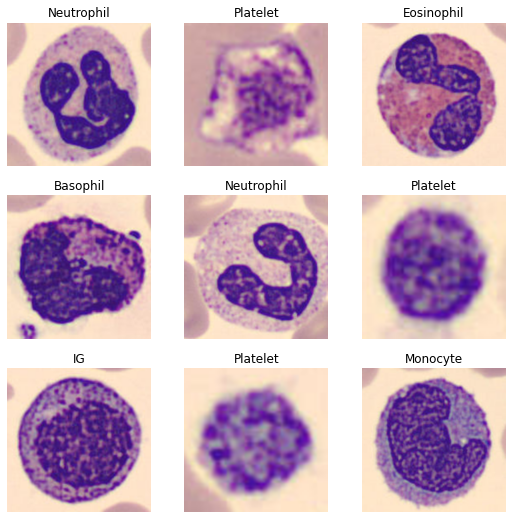

In [3]:
dls.show_batch()
dls.vocab
dls.vocab.o2i

# Train Model

Need to explain resnet34 architecture.
Metrics used:


*   Accuracy
*   Error Rate
*   Precision (more weight given to larger categories)
*   Recall (more weight given to large categories)
*   F1 Score (more weight given to large categories)
*   RocAuc

N.B. Micro average used because of class imbalance in training dataset. See referenced article:

https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin


In [4]:
learn = cnn_learner(dls, resnet34, metrics=[accuracy, error_rate, Precision(average="micro"), Recall(average="micro"), F1Score(average="micro"), RocAuc(average="macro", multi_class="ovo")])

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [5]:
learn.fit_one_cycle(4)
learn.save('stage_1')

epoch,train_loss,valid_loss,accuracy,error_rate,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.355127,0.126704,0.959220,0.040780,0.959220,0.959220,0.959220,0.998148,02:41
1,0.135005,0.071330,0.976312,0.023688,0.976312,0.976312,0.976312,0.999247,02:41
2,0.084499,0.061551,0.980810,0.019190,0.980810,0.980810,0.980810,0.999465,02:40
3,0.046136,0.058193,0.981409,0.018591,0.981409,0.981409,0.981409,0.999523,02:40


Path('/content/PBC_dataset_normal_DIB_cropped/models/stage_1.pth')

# Evaluate Model

Here we reload a previously trained CNN.


*   Learning Rate finder allows you to find optimal learning rate to converge. A excessively high learning rate produces instability. An excessively low learning rate produces training that never converges.
*   A frozen layer is essentially a layer that does not learn during back-propagation. Unfreezing all layers allows them to learn again.

Prediction Memory Issue (UNRESOLVED)
https://forums.fast.ai/t/learn-get-preds-memory-inefficiency-quick-fix/84029/20


In [ ]:
#learn = cnn_learner(dls, resnet34, metrics=error_rate)
#learn.load('stage_1');
#interp = ClassificationInterpretation.from_learner(learn) #interpretations from model
#losses,idxs = interp.top_losses() #worst predictions

SuggestedLRs(valley=0.0003311311302240938)

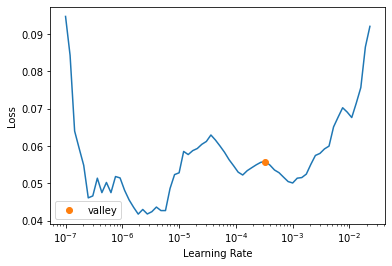

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.load('stage_1');
learn.lr_find()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, lr_max=3.3e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.242357,0.374168,0.091281,06:21
1,0.122957,0.219772,0.060854,06:17
2,0.051330,0.050436,0.016384,06:17
3,0.018325,0.035397,0.011118,06:17


In [ ]:
learn.summary()

In [ ]:
class Interpretation():
    "Interpretation base class, can be inherited for task specific Interpretation classes"
    def __init__(self, dl, preds, targs, decoded, losses): store_attr()

    def __getitem__(self, idxs):
        "Get the the inputs, preds, targs, decoded outputs, and losses at `idxs`"
        if isinstance(idxs, Tensor): idxs = idxs.tolist()
        if not is_listy(idxs): idxs = [idxs]
        attrs = 'preds,targs,decoded,losses'
        res = L([getattr(self, attr)[idxs] for attr in attrs.split(',')])
        # Gather and preprocess inputs without needing all of them in memory
        inps = [self.dl.do_item(o)[:self.dl.n_inp] for o in idxs]
        inps = self.dl.after_batch(to_device(self.dl.do_batch(inps), self.dl.device))
        return inps + res

    @classmethod
    def from_learner(cls, learn, ds_idx=1, dl=None, act=None):
        "Construct interpretation object from a learner"
        if dl is None: dl = learn.dls[ds_idx]
        return cls(dl, *learn.get_preds(dl=dl, with_input=False, with_loss=True, with_decoded=True, act=None))

    def top_losses(self, k=None, largest=True):
        "`k` largest(/smallest) losses and indexes, defaulting to all losses (sorted by `largest`)."
        return self.losses.topk(ifnone(k, len(self.losses)), largest=largest)

    def plot_top_losses(self, k, largest=True, **kwargs):
        losses,idx = self.top_losses(k, largest)
        inps, preds, targs, decoded, _ = self[idx]
        if not isinstance(inps, tuple): inps = (inps,)
        b = inps + (targs,)
        x,y,its = self.dl._pre_show_batch(b, max_n=k)
        b_out = inps + (decoded,)
        x1,y1,outs = self.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), preds, losses,  **kwargs)

N.B. These are still images from the dataset provided by Acevedo et. al.

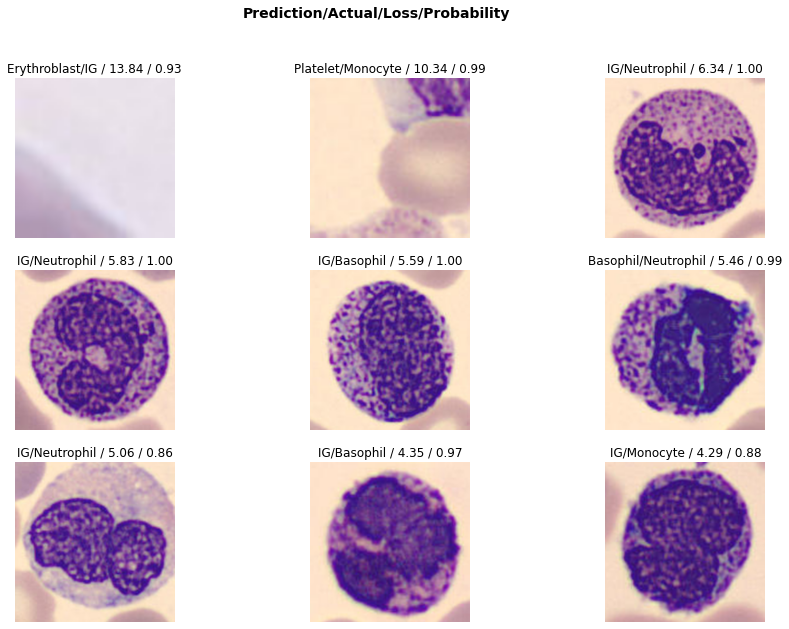

In [ ]:

interp = Interpretation.from_learner(learn) #interpretations from model
interp.plot_top_losses(9, figsize=(15,10)) #worst predictions
#interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
learn.predict("/content/PBC_dataset_normal_DIB/basophil/BA_100102.jpg")

('Basophil',
 TensorBase(0),
 TensorBase([9.1284e-01, 4.6600e-07, 6.8423e-04, 2.0740e-05, 8.6445e-02, 2.9480e-06,
         1.7611e-06, 1.4565e-06]))

# Prediction on Unseen Data

Testing the model on unseen images.

In [ ]:
learn.export()

In [ ]:
path = "/content/PBC_dataset_normal_DIB/export.pkl"
learn = load_learner(path)

In [ ]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/BCCD_cropped_wbc_classified_test_set.zip

Something quick and temporary. Goes through every file and makes a prediction. As you can see virtually all of them are wrong.

In [28]:
root = '/content/BCCD_cropped_wbc_classified_test_set'
bccd_dataset_cat = ['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']
for wbc in bccd_dataset_cat:
  print("--->>> True category for all below is", wbc, '<<<---')
  path = os.path.join(root, wbc)
  for filename in os.listdir(path):
    file_path = os.path.join(root, wbc, filename)
    print(learn.predict(file_path))

--->>> True category for all below is basophil <<<---


('Monocyte', TensorBase(5), TensorBase([4.4264e-07, 4.9716e-07, 9.5691e-02, 2.6847e-01, 6.6155e-04, 6.1212e-01,
        7.0852e-05, 2.2984e-02]))


('IG', TensorBase(3), TensorBase([7.3912e-06, 1.5307e-08, 3.1392e-06, 9.9266e-01, 1.3773e-06, 7.3040e-03,
        1.7131e-05, 2.4218e-06]))
--->>> True category for all below is eosinophil <<<---


('Platelet', TensorBase(7), TensorBase([8.8078e-05, 4.0293e-04, 2.5200e-01, 5.4789e-03, 2.4979e-03, 1.4964e-02,
        3.9101e-03, 7.2066e-01]))


('Erythroblast', TensorBase(2), TensorBase([6.7706e-06, 4.5005e-08, 9.2982e-01, 1.2600e-03, 8.1771e-06, 6.4002e-05,
        7.4106e-05, 6.8762e-02]))


('Erythroblast', TensorBase(2), TensorBase([9.2451e-05, 2.4909e-05, 8.5088e-01, 4.8276e-02, 7.0866e-03, 5.2671e-02,
        3.5724e-03, 3.7399e-02]))


('Monocyte', TensorBase(5), TensorBase([1.4170e-03, 4.2877e-03, 3.0195e-03, 4.9249e-02, 6.3845e-04, 8.5128e-01,
        5.5390e-03, 8.4572e-02]))


('IG', TensorBase(3), TensorBase([2.1397e-06, 2.4019e-02, 5.0246e-03, 4.4204e-01, 4.6741e-04, 1.2163e-01,
        2.0857e-04, 4.0660e-01]))


('Erythroblast', TensorBase(2), TensorBase([5.1465e-06, 2.8772e-04, 5.4528e-01, 2.4310e-01, 1.0486e-04, 1.6709e-01,
        7.6265e-03, 3.6509e-02]))


('Platelet', TensorBase(7), TensorBase([1.8972e-04, 4.7074e-05, 4.4317e-01, 8.0903e-02, 2.2316e-03, 8.8013e-03,
        1.4899e-02, 4.4976e-01]))


('Erythroblast', TensorBase(2), TensorBase([3.8926e-05, 7.4949e-05, 9.8586e-01, 1.8052e-03, 4.4003e-05, 8.4325e-05,
        3.1823e-03, 8.9054e-03]))


('Monocyte', TensorBase(5), TensorBase([2.7371e-05, 2.6078e-03, 1.8012e-01, 1.6411e-01, 1.1539e-03, 4.2904e-01,
        4.1953e-02, 1.8098e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.9923e-06, 2.9289e-08, 9.7592e-01, 7.6644e-05, 4.9985e-07, 2.2803e-06,
        1.0753e-06, 2.3993e-02]))


('Erythroblast', TensorBase(2), TensorBase([2.2873e-05, 6.0813e-05, 9.2571e-01, 6.1984e-03, 9.5748e-05, 4.0987e-04,
        2.1242e-02, 4.6264e-02]))


('Erythroblast', TensorBase(2), TensorBase([6.6865e-06, 1.2881e-08, 9.7678e-01, 8.8899e-06, 2.3236e-05, 1.2565e-04,
        4.0994e-07, 2.3054e-02]))


('Erythroblast', TensorBase(2), TensorBase([6.9283e-06, 1.0063e-04, 8.1377e-01, 6.4166e-02, 5.6475e-05, 4.1745e-02,
        1.5240e-02, 6.4913e-02]))


('Erythroblast', TensorBase(2), TensorBase([2.3201e-06, 1.2016e-07, 9.2834e-01, 6.9783e-04, 1.3234e-04, 7.6967e-04,
        7.6538e-05, 6.9984e-02]))


('Erythroblast', TensorBase(2), TensorBase([1.7775e-06, 3.3885e-06, 9.6388e-01, 6.4799e-06, 8.6151e-04, 4.1470e-04,
        1.4137e-05, 3.4817e-02]))


('Erythroblast', TensorBase(2), TensorBase([5.9150e-06, 1.0951e-07, 8.6694e-01, 1.7859e-06, 1.5430e-04, 7.6301e-04,
        6.6212e-06, 1.3213e-01]))


('Platelet', TensorBase(7), TensorBase([3.2414e-07, 1.7733e-04, 3.8244e-02, 9.4591e-07, 5.2921e-04, 1.2732e-04,
        2.3684e-06, 9.6092e-01]))


('Erythroblast', TensorBase(2), TensorBase([4.3339e-06, 6.2191e-05, 6.0833e-01, 4.8804e-03, 7.5802e-02, 9.2382e-03,
        3.2900e-03, 2.9839e-01]))


('Platelet', TensorBase(7), TensorBase([2.6992e-06, 1.5309e-05, 3.8072e-01, 8.6204e-05, 1.7807e-04, 1.7859e-03,
        1.0159e-04, 6.1711e-01]))


('Monocyte', TensorBase(5), TensorBase([9.2811e-06, 5.9710e-04, 3.7102e-01, 1.1545e-01, 2.0482e-02, 4.1937e-01,
        2.5250e-04, 7.2817e-02]))


('Platelet', TensorBase(7), TensorBase([8.0917e-06, 2.8226e-02, 3.6660e-02, 8.9942e-02, 8.6000e-04, 1.4261e-01,
        1.1209e-03, 7.0058e-01]))


('Platelet', TensorBase(7), TensorBase([1.1999e-05, 1.5545e-03, 4.5895e-02, 1.0386e-02, 1.7600e-01, 5.4067e-02,
        3.5157e-03, 7.0857e-01]))


('IG', TensorBase(3), TensorBase([1.4682e-05, 5.4977e-03, 2.2015e-01, 6.7360e-01, 8.5709e-03, 3.0498e-02,
        3.7027e-02, 2.4635e-02]))


('Erythroblast', TensorBase(2), TensorBase([3.6083e-06, 1.4741e-03, 8.6411e-01, 9.7471e-03, 1.3560e-04, 9.3364e-04,
        7.5135e-03, 1.1608e-01]))


('Erythroblast', TensorBase(2), TensorBase([2.2244e-06, 5.7451e-07, 6.8373e-01, 5.4067e-03, 1.9482e-05, 2.5147e-05,
        4.8335e-04, 3.1033e-01]))


('IG', TensorBase(3), TensorBase([3.3608e-05, 3.1180e-04, 1.6693e-01, 7.3626e-01, 3.5676e-04, 2.8449e-02,
        1.4565e-02, 5.3092e-02]))


('Platelet', TensorBase(7), TensorBase([1.5518e-06, 6.2239e-09, 3.5214e-01, 1.2403e-06, 2.8859e-05, 1.1035e-04,
        9.6675e-08, 6.4772e-01]))


('IG', TensorBase(3), TensorBase([1.0859e-05, 1.5391e-02, 2.3590e-01, 4.3761e-01, 1.6488e-03, 1.1370e-01,
        4.7229e-03, 1.9102e-01]))


('Monocyte', TensorBase(5), TensorBase([6.2583e-06, 9.6349e-05, 1.0693e-03, 1.0233e-01, 5.5794e-03, 8.7934e-01,
        3.4673e-04, 1.1227e-02]))


('IG', TensorBase(3), TensorBase([6.1572e-06, 2.6711e-05, 3.0375e-04, 5.6623e-01, 2.2516e-04, 4.3276e-01,
        5.1734e-05, 4.0604e-04]))


('Erythroblast', TensorBase(2), TensorBase([5.4824e-07, 5.0547e-08, 8.6933e-01, 6.3422e-07, 7.4256e-06, 1.2854e-05,
        3.3698e-06, 1.3065e-01]))


('Erythroblast', TensorBase(2), TensorBase([4.7114e-05, 4.8176e-03, 5.2420e-01, 1.6153e-01, 5.7905e-04, 2.4152e-02,
        2.7596e-01, 8.7144e-03]))


('Erythroblast', TensorBase(2), TensorBase([2.9965e-07, 1.9720e-06, 9.4381e-01, 2.0991e-05, 1.5958e-05, 9.5814e-05,
        1.9610e-06, 5.6056e-02]))


('Monocyte', TensorBase(5), TensorBase([3.1901e-06, 1.2865e-04, 5.5818e-02, 3.8699e-02, 1.9444e-02, 8.0897e-01,
        4.6456e-04, 7.6475e-02]))


('Platelet', TensorBase(7), TensorBase([4.4143e-06, 1.2860e-04, 9.1365e-03, 2.0601e-04, 3.8431e-04, 1.7722e-03,
        1.2959e-05, 9.8835e-01]))


('Erythroblast', TensorBase(2), TensorBase([4.7895e-05, 5.1024e-06, 9.2135e-01, 1.2658e-03, 1.4186e-04, 6.7745e-05,
        3.6310e-04, 7.6763e-02]))


('Platelet', TensorBase(7), TensorBase([1.2036e-06, 2.5726e-05, 2.6215e-03, 3.2149e-05, 3.8361e-04, 1.3554e-03,
        2.4430e-05, 9.9556e-01]))


('Erythroblast', TensorBase(2), TensorBase([5.7669e-06, 2.8790e-03, 6.5813e-01, 2.1466e-01, 1.8626e-04, 7.7234e-03,
        1.5260e-02, 1.0116e-01]))


('Erythroblast', TensorBase(2), TensorBase([2.1808e-06, 1.8661e-06, 7.2613e-01, 3.5042e-05, 2.2556e-04, 1.7620e-04,
        3.7742e-06, 2.7343e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.7050e-05, 6.6824e-05, 6.1937e-01, 8.7469e-05, 3.0214e-02, 1.7860e-03,
        4.4569e-04, 3.4802e-01]))


('Monocyte', TensorBase(5), TensorBase([1.3763e-05, 9.4081e-03, 1.3855e-02, 1.4921e-02, 8.5006e-04, 6.9331e-01,
        3.2361e-02, 2.3528e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.2410e-05, 1.6008e-03, 9.1001e-01, 2.6500e-02, 2.0470e-04, 5.0423e-03,
        4.2589e-03, 5.2376e-02]))


('Erythroblast', TensorBase(2), TensorBase([6.2117e-06, 7.6308e-06, 6.5766e-01, 3.0719e-05, 1.2825e-02, 4.8908e-03,
        1.5980e-03, 3.2298e-01]))


('Erythroblast', TensorBase(2), TensorBase([4.4327e-07, 5.7959e-02, 7.5523e-01, 4.9947e-04, 2.6051e-03, 1.2767e-02,
        1.5348e-04, 1.7079e-01]))


('Platelet', TensorBase(7), TensorBase([5.2360e-06, 6.9665e-04, 3.3488e-01, 8.8684e-04, 7.3462e-04, 1.3198e-03,
        9.3673e-05, 6.6139e-01]))


('Erythroblast', TensorBase(2), TensorBase([4.0519e-05, 9.3455e-06, 7.9391e-01, 3.4557e-04, 6.9109e-03, 1.5632e-02,
        1.4548e-03, 1.8169e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.7659e-07, 5.5038e-06, 8.8544e-01, 3.5419e-06, 1.6040e-05, 1.8328e-04,
        2.9172e-05, 1.1432e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.2346e-07, 2.4055e-08, 9.9660e-01, 1.2184e-07, 1.0772e-05, 1.3411e-05,
        2.0959e-06, 3.3770e-03]))


('Monocyte', TensorBase(5), TensorBase([2.6965e-04, 2.1735e-04, 3.2985e-03, 3.8872e-01, 1.1208e-03, 5.9439e-01,
        3.8844e-04, 1.1595e-02]))


('Monocyte', TensorBase(5), TensorBase([9.3884e-06, 9.3837e-04, 3.5813e-02, 1.7614e-01, 1.8798e-04, 7.7607e-01,
        9.3087e-03, 1.5331e-03]))


('Erythroblast', TensorBase(2), TensorBase([3.3153e-05, 3.3318e-05, 6.5548e-01, 2.9118e-01, 8.1867e-04, 2.6077e-02,
        1.0837e-03, 2.5296e-02]))


('Erythroblast', TensorBase(2), TensorBase([4.5383e-05, 1.6002e-03, 7.7055e-01, 1.4440e-01, 3.9930e-04, 4.1914e-03,
        2.5324e-03, 7.6288e-02]))


('Erythroblast', TensorBase(2), TensorBase([1.8397e-05, 1.7070e-01, 3.6641e-01, 1.0519e-01, 3.2498e-03, 6.8324e-02,
        9.2304e-02, 1.9381e-01]))


('Platelet', TensorBase(7), TensorBase([3.2580e-06, 3.1072e-06, 1.4389e-01, 1.3590e-03, 1.6375e-03, 5.0901e-03,
        1.3134e-04, 8.4788e-01]))


('IG', TensorBase(3), TensorBase([1.9655e-06, 3.7961e-05, 1.4232e-02, 9.8253e-01, 6.3871e-07, 1.5964e-03,
        6.6280e-04, 9.4233e-04]))


('Platelet', TensorBase(7), TensorBase([1.6144e-05, 1.8463e-03, 2.9219e-02, 1.1686e-01, 2.8038e-03, 2.0882e-02,
        3.9365e-03, 8.2444e-01]))


('Platelet', TensorBase(7), TensorBase([1.8845e-05, 1.7308e-02, 2.4118e-02, 4.0923e-01, 3.8121e-04, 5.6637e-02,
        1.0673e-03, 4.9124e-01]))
--->>> True category for all below is lymphocyte <<<---


('Erythroblast', TensorBase(2), TensorBase([1.2722e-05, 6.4163e-08, 9.4832e-01, 5.5538e-05, 1.1209e-03, 1.4674e-03,
        1.8393e-06, 4.9017e-02]))


('Erythroblast', TensorBase(2), TensorBase([6.4318e-07, 1.7120e-08, 8.9440e-01, 4.1406e-07, 1.6600e-05, 3.1550e-05,
        1.3553e-08, 1.0555e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.2833e-05, 4.8435e-06, 8.4527e-01, 8.2900e-05, 1.8884e-03, 3.4276e-03,
        1.3866e-04, 1.4917e-01]))


('Erythroblast', TensorBase(2), TensorBase([4.2380e-06, 8.9829e-07, 8.8349e-01, 2.7232e-04, 4.5641e-04, 1.8569e-03,
        2.6519e-06, 1.1392e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.1235e-06, 3.1832e-07, 9.6544e-01, 3.8533e-04, 4.9196e-04, 1.3147e-04,
        3.6831e-06, 3.3542e-02]))


('Erythroblast', TensorBase(2), TensorBase([1.5421e-06, 2.5531e-09, 9.8781e-01, 4.1208e-07, 1.7276e-05, 1.3026e-05,
        2.7385e-08, 1.2162e-02]))


('Erythroblast', TensorBase(2), TensorBase([3.7751e-06, 4.3579e-08, 9.2027e-01, 3.4313e-07, 8.2349e-05, 5.1395e-05,
        1.4896e-08, 7.9589e-02]))


('Platelet', TensorBase(7), TensorBase([1.1592e-05, 9.8953e-08, 4.5442e-01, 8.7153e-06, 1.1150e-05, 4.4719e-05,
        3.2858e-07, 5.4551e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.5836e-06, 3.4643e-07, 9.5934e-01, 6.5183e-07, 2.9933e-02, 4.1736e-04,
        1.0350e-06, 1.0307e-02]))


('Erythroblast', TensorBase(2), TensorBase([1.1749e-06, 3.6593e-06, 9.8555e-01, 9.6930e-04, 3.9645e-04, 1.0288e-03,
        1.1154e-02, 8.9963e-04]))


('Erythroblast', TensorBase(2), TensorBase([3.3301e-07, 1.2517e-07, 9.9768e-01, 4.3288e-05, 2.9887e-04, 1.1773e-04,
        2.1233e-06, 1.8532e-03]))


('Erythroblast', TensorBase(2), TensorBase([6.5563e-07, 1.0867e-08, 9.9138e-01, 2.1494e-06, 1.1100e-05, 2.1331e-06,
        1.2875e-09, 8.6018e-03]))


('Erythroblast', TensorBase(2), TensorBase([3.9952e-06, 4.7596e-07, 9.8880e-01, 2.1826e-04, 5.6662e-05, 5.7518e-05,
        3.4105e-07, 1.0858e-02]))


('Erythroblast', TensorBase(2), TensorBase([6.8206e-07, 3.7438e-08, 9.8336e-01, 1.7163e-07, 9.1869e-04, 3.3037e-04,
        1.1613e-07, 1.5386e-02]))


('Erythroblast', TensorBase(2), TensorBase([3.1151e-05, 2.0242e-08, 9.8676e-01, 4.7181e-06, 2.6670e-04, 3.1504e-04,
        2.3261e-06, 1.2619e-02]))


('Erythroblast', TensorBase(2), TensorBase([4.4233e-07, 1.7176e-07, 9.9433e-01, 1.9777e-06, 8.8209e-04, 5.0174e-04,
        9.8789e-07, 4.2839e-03]))


('Erythroblast', TensorBase(2), TensorBase([7.2991e-06, 1.3667e-08, 9.6478e-01, 5.1385e-05, 5.7637e-05, 5.0344e-05,
        7.5189e-05, 3.4982e-02]))


('Erythroblast', TensorBase(2), TensorBase([7.7125e-06, 1.2180e-07, 8.5507e-01, 1.9937e-05, 3.4857e-05, 3.0259e-05,
        4.1073e-05, 1.4480e-01]))


('Erythroblast', TensorBase(2), TensorBase([4.4135e-08, 8.7699e-07, 9.9870e-01, 1.5147e-04, 1.1876e-04, 4.8446e-04,
        1.8349e-05, 5.2533e-04]))


('Platelet', TensorBase(7), TensorBase([1.7343e-06, 1.2910e-05, 3.5361e-02, 1.5723e-04, 1.3923e-01, 8.8013e-02,
        1.1045e-03, 7.3612e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.7525e-05, 3.3839e-08, 8.9942e-01, 4.4857e-06, 2.4790e-05, 4.9712e-05,
        1.0288e-07, 1.0048e-01]))


('Platelet', TensorBase(7), TensorBase([1.3085e-07, 4.0719e-08, 8.1910e-03, 3.0084e-07, 5.5996e-04, 1.8214e-03,
        6.5219e-07, 9.8943e-01]))


('Erythroblast', TensorBase(2), TensorBase([2.9269e-06, 1.9136e-06, 9.8124e-01, 1.5279e-03, 1.2121e-03, 9.3443e-04,
        4.5841e-04, 1.4622e-02]))


('Erythroblast', TensorBase(2), TensorBase([7.1696e-08, 3.6259e-08, 9.9957e-01, 1.2500e-06, 1.0296e-04, 5.2105e-06,
        6.8035e-06, 3.1185e-04]))


('Erythroblast', TensorBase(2), TensorBase([1.8023e-05, 1.0338e-07, 9.8271e-01, 1.8392e-04, 9.9495e-06, 9.4694e-06,
        2.5638e-07, 1.7064e-02]))


('Erythroblast', TensorBase(2), TensorBase([6.3647e-06, 1.0598e-07, 8.7957e-01, 4.2218e-07, 1.0716e-05, 1.1188e-04,
        1.3279e-08, 1.2030e-01]))


('Erythroblast', TensorBase(2), TensorBase([3.4192e-06, 8.6231e-09, 9.9244e-01, 1.9219e-07, 3.0306e-05, 2.9294e-05,
        1.0133e-08, 7.4968e-03]))


('Erythroblast', TensorBase(2), TensorBase([8.5144e-08, 2.6748e-09, 9.9873e-01, 1.0538e-06, 7.8544e-06, 1.0502e-05,
        5.2578e-08, 1.2525e-03]))


('Erythroblast', TensorBase(2), TensorBase([1.9172e-06, 1.1516e-07, 9.0783e-01, 1.4230e-06, 4.1198e-05, 1.5365e-05,
        1.4796e-08, 9.2108e-02]))


('Erythroblast', TensorBase(2), TensorBase([4.0699e-05, 5.2589e-08, 9.9206e-01, 2.1589e-04, 2.5062e-04, 7.1491e-05,
        3.4777e-06, 7.3569e-03]))


('Erythroblast', TensorBase(2), TensorBase([1.1727e-06, 1.8304e-08, 9.9883e-01, 1.7145e-05, 4.6756e-05, 9.8983e-06,
        1.3429e-06, 1.0921e-03]))


('Erythroblast', TensorBase(2), TensorBase([1.6557e-05, 5.5237e-08, 9.7564e-01, 8.1643e-06, 1.7158e-05, 4.6390e-06,
        2.6560e-08, 2.4315e-02]))


('Erythroblast', TensorBase(2), TensorBase([8.2516e-06, 1.7659e-06, 9.9137e-01, 1.3784e-05, 4.9541e-04, 1.7987e-03,
        1.4999e-03, 4.8107e-03]))


('Erythroblast', TensorBase(2), TensorBase([8.0927e-06, 1.5286e-07, 8.9286e-01, 1.8777e-04, 4.6042e-04, 1.3455e-03,
        6.8044e-06, 1.0513e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.2025e-04, 2.1124e-07, 8.4547e-01, 4.1287e-05, 3.8740e-04, 5.2420e-04,
        1.2980e-05, 1.5344e-01]))


('Lymphocyte', TensorBase(4), TensorBase([9.8375e-07, 4.6528e-06, 1.8135e-01, 8.1336e-05, 7.9529e-01, 3.5444e-03,
        1.4156e-05, 1.9719e-02]))
--->>> True category for all below is monocyte <<<---


('Platelet', TensorBase(7), TensorBase([9.3373e-05, 1.1033e-05, 9.2721e-02, 1.9932e-02, 2.4493e-03, 8.4385e-02,
        2.6771e-02, 7.7364e-01]))


('Monocyte', TensorBase(5), TensorBase([2.2838e-07, 7.6504e-06, 8.3659e-04, 1.1741e-01, 9.2955e-05, 8.7240e-01,
        1.5729e-04, 9.0864e-03]))


('Erythroblast', TensorBase(2), TensorBase([4.6282e-07, 4.5813e-07, 9.6516e-01, 3.6256e-05, 1.5735e-03, 3.3465e-04,
        3.8293e-05, 3.2860e-02]))


('Erythroblast', TensorBase(2), TensorBase([8.2449e-06, 2.0311e-06, 7.0748e-01, 1.1785e-01, 2.0364e-03, 9.3242e-03,
        5.0811e-03, 1.5822e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.7455e-06, 3.5019e-06, 5.5329e-01, 2.4671e-01, 8.3602e-04, 8.0738e-02,
        1.5891e-03, 1.1683e-01]))


('IG', TensorBase(3), TensorBase([2.3290e-05, 1.2388e-05, 1.3791e-01, 8.4962e-01, 5.4982e-04, 3.1122e-03,
        7.9330e-03, 8.4682e-04]))


('Erythroblast', TensorBase(2), TensorBase([6.9920e-06, 1.6073e-06, 8.8747e-01, 1.5086e-02, 7.1929e-04, 9.0346e-05,
        3.1061e-05, 9.6596e-02]))


('Monocyte', TensorBase(5), TensorBase([3.0836e-06, 1.1535e-05, 6.3811e-02, 6.9662e-03, 2.9554e-03, 8.3111e-01,
        2.1508e-03, 9.2996e-02]))


('IG', TensorBase(3), TensorBase([2.0761e-06, 7.5588e-06, 1.3030e-02, 7.5030e-01, 2.7686e-05, 2.2874e-01,
        7.7561e-04, 7.1155e-03]))


('Erythroblast', TensorBase(2), TensorBase([2.4498e-05, 2.4229e-06, 4.3794e-01, 5.6094e-02, 2.4956e-02, 7.8406e-02,
        6.8287e-04, 4.0190e-01]))


('Monocyte', TensorBase(5), TensorBase([6.4987e-08, 2.6973e-05, 2.3961e-04, 2.0521e-02, 1.7706e-03, 9.7475e-01,
        7.3921e-04, 1.9478e-03]))


('Platelet', TensorBase(7), TensorBase([6.3355e-06, 2.1174e-07, 2.4527e-01, 1.3144e-05, 5.6021e-05, 8.2761e-05,
        1.4146e-06, 7.5457e-01]))


('Platelet', TensorBase(7), TensorBase([4.6439e-06, 4.1058e-07, 1.6619e-01, 6.3487e-06, 2.0264e-03, 5.0892e-04,
        1.3364e-05, 8.3125e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.9537e-07, 1.3801e-08, 9.8562e-01, 8.9867e-07, 3.6655e-04, 1.9987e-05,
        5.7372e-07, 1.3994e-02]))


('Erythroblast', TensorBase(2), TensorBase([1.9605e-05, 2.5189e-06, 8.4482e-01, 1.6344e-03, 5.7218e-04, 1.1169e-03,
        5.9589e-05, 1.5178e-01]))


('Monocyte', TensorBase(5), TensorBase([9.0655e-07, 3.7369e-06, 9.3715e-04, 4.0848e-02, 1.8941e-05, 9.3920e-01,
        1.3976e-02, 5.0107e-03]))


('Erythroblast', TensorBase(2), TensorBase([1.1923e-07, 2.2026e-07, 8.9087e-01, 5.1398e-05, 1.0728e-03, 3.2801e-04,
        4.8584e-05, 1.0763e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.8791e-04, 1.7111e-05, 6.2450e-01, 1.3801e-03, 1.1195e-03, 2.0813e-02,
        5.6519e-04, 3.5142e-01]))


('Monocyte', TensorBase(5), TensorBase([1.3304e-05, 1.5095e-05, 2.8609e-01, 4.9256e-02, 2.2415e-03, 5.9916e-01,
        7.3844e-03, 5.5834e-02]))


('IG', TensorBase(3), TensorBase([3.7744e-05, 2.3155e-06, 3.1655e-02, 7.9405e-01, 3.0816e-04, 1.4904e-01,
        1.7031e-03, 2.3202e-02]))


('Monocyte', TensorBase(5), TensorBase([7.6588e-07, 2.8156e-06, 1.7853e-01, 2.6245e-03, 9.3170e-04, 7.6420e-01,
        1.8595e-02, 3.5112e-02]))
--->>> True category for all below is neutrophil <<<---


('Neutrophil', TensorBase(6), TensorBase([1.3028e-04, 1.1258e-04, 1.5393e-01, 3.8269e-01, 3.5919e-03, 1.7292e-02,
        4.1334e-01, 2.8908e-02]))


('Neutrophil', TensorBase(6), TensorBase([3.4130e-06, 4.0606e-06, 3.1882e-01, 1.7161e-02, 4.5293e-05, 2.0825e-02,
        6.3257e-01, 1.0566e-02]))


('Monocyte', TensorBase(5), TensorBase([3.3231e-06, 3.6587e-05, 2.1773e-02, 1.1798e-02, 4.1112e-05, 6.1352e-01,
        3.4151e-01, 1.1316e-02]))


('Erythroblast', TensorBase(2), TensorBase([3.5443e-06, 4.8572e-07, 9.6212e-01, 2.6853e-03, 1.9768e-05, 7.0788e-03,
        1.8427e-02, 9.6680e-03]))


('Platelet', TensorBase(7), TensorBase([5.2030e-05, 9.2499e-07, 4.4775e-01, 1.3986e-03, 7.3221e-03, 1.0114e-02,
        6.5458e-04, 5.3271e-01]))


('Erythroblast', TensorBase(2), TensorBase([4.7010e-05, 4.0450e-07, 7.1343e-01, 1.4890e-04, 2.4648e-04, 8.4571e-04,
        2.6937e-04, 2.8502e-01]))


('Erythroblast', TensorBase(2), TensorBase([2.4877e-05, 5.8394e-06, 9.2035e-01, 4.6477e-04, 5.7498e-05, 2.3867e-03,
        2.5469e-02, 5.1244e-02]))


('Erythroblast', TensorBase(2), TensorBase([7.0264e-08, 4.0026e-08, 9.5906e-01, 4.9182e-05, 2.5356e-05, 1.4770e-04,
        6.4912e-06, 4.0714e-02]))


('Erythroblast', TensorBase(2), TensorBase([3.4137e-07, 1.3946e-07, 9.8714e-01, 9.5675e-05, 3.9256e-07, 1.3907e-03,
        9.6339e-03, 1.7374e-03]))


('Platelet', TensorBase(7), TensorBase([5.9418e-04, 9.7798e-05, 1.5379e-01, 6.6635e-02, 6.8771e-03, 1.6854e-01,
        1.4497e-02, 5.8897e-01]))


('Neutrophil', TensorBase(6), TensorBase([4.7456e-06, 2.3991e-05, 4.0583e-01, 1.6444e-02, 1.3511e-03, 4.0946e-03,
        5.5816e-01, 1.4091e-02]))


('Erythroblast', TensorBase(2), TensorBase([1.1545e-05, 5.9644e-07, 9.9825e-01, 4.5033e-04, 9.8930e-06, 4.7511e-06,
        2.8605e-05, 1.2449e-03]))


('Erythroblast', TensorBase(2), TensorBase([1.1917e-05, 7.9159e-08, 5.6299e-01, 2.8364e-05, 2.0005e-04, 2.7825e-04,
        1.5659e-07, 4.3649e-01]))


('Platelet', TensorBase(7), TensorBase([1.2162e-04, 2.2978e-06, 2.3455e-01, 9.6486e-03, 1.6016e-04, 1.7799e-04,
        1.6013e-03, 7.5374e-01]))


('Erythroblast', TensorBase(2), TensorBase([5.9421e-08, 2.1535e-07, 9.6833e-01, 7.3480e-06, 4.8857e-05, 6.9384e-05,
        1.2699e-05, 3.1536e-02]))


('Platelet', TensorBase(7), TensorBase([4.4734e-07, 4.2865e-08, 4.7293e-01, 4.0368e-05, 2.5483e-06, 1.3208e-04,
        1.1794e-07, 5.2690e-01]))


('Platelet', TensorBase(7), TensorBase([3.2906e-04, 6.8669e-05, 1.2687e-01, 1.6414e-01, 3.1470e-03, 3.9112e-02,
        1.3962e-01, 5.2671e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.8442e-07, 7.0445e-09, 9.9251e-01, 2.0442e-06, 5.7442e-06, 1.3739e-04,
        2.6316e-06, 7.3468e-03]))


('Erythroblast', TensorBase(2), TensorBase([6.9810e-07, 2.3238e-05, 7.7982e-01, 5.6292e-04, 6.4965e-05, 8.5722e-04,
        2.1822e-01, 4.5529e-04]))


('Neutrophil', TensorBase(6), TensorBase([7.0013e-06, 2.8176e-05, 1.1025e-01, 6.6101e-04, 1.4258e-05, 7.5551e-02,
        7.9894e-01, 1.4544e-02]))


('Erythroblast', TensorBase(2), TensorBase([6.4631e-05, 2.0273e-06, 5.7357e-01, 8.1277e-04, 5.1432e-04, 4.8190e-04,
        2.3019e-03, 4.2225e-01]))


('Erythroblast', TensorBase(2), TensorBase([2.5481e-07, 2.3976e-06, 9.7854e-01, 2.4695e-03, 7.0573e-06, 6.8205e-04,
        1.6995e-02, 1.3090e-03]))


('Platelet', TensorBase(7), TensorBase([2.9684e-05, 1.2461e-06, 4.4755e-01, 1.7133e-03, 3.8652e-04, 9.4547e-03,
        1.4584e-02, 5.2628e-01]))


('Platelet', TensorBase(7), TensorBase([2.2657e-06, 8.9816e-07, 3.2865e-01, 1.3502e-02, 1.7618e-05, 1.3361e-04,
        1.5019e-05, 6.5768e-01]))


('Erythroblast', TensorBase(2), TensorBase([2.7637e-06, 1.0044e-07, 5.4934e-01, 5.1464e-05, 6.1422e-06, 1.1860e-04,
        6.6696e-05, 4.5042e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.6276e-05, 1.2669e-06, 9.4436e-01, 9.4307e-04, 1.9286e-04, 2.2842e-02,
        9.1948e-03, 2.2448e-02]))


('Erythroblast', TensorBase(2), TensorBase([8.2754e-07, 3.2079e-08, 7.7287e-01, 3.1441e-05, 4.2421e-06, 2.6815e-04,
        4.3637e-06, 2.2682e-01]))


('Platelet', TensorBase(7), TensorBase([4.0046e-05, 1.0374e-05, 2.3070e-01, 1.6396e-02, 9.7018e-04, 5.6076e-02,
        1.8821e-02, 6.7699e-01]))


('Erythroblast', TensorBase(2), TensorBase([3.1476e-07, 5.0583e-09, 9.9883e-01, 1.9676e-06, 4.4549e-07, 4.1463e-06,
        2.5868e-06, 1.1575e-03]))


('Erythroblast', TensorBase(2), TensorBase([6.0502e-05, 2.6407e-04, 5.5415e-01, 3.7471e-02, 4.1866e-04, 2.7722e-02,
        3.1997e-01, 5.9947e-02]))


('Erythroblast', TensorBase(2), TensorBase([2.8371e-05, 1.5861e-06, 5.5987e-01, 7.9078e-04, 3.7082e-04, 8.0044e-04,
        3.7888e-05, 4.3810e-01]))


('Neutrophil', TensorBase(6), TensorBase([1.3439e-05, 2.2976e-05, 4.4206e-01, 8.6106e-05, 4.6550e-06, 2.8858e-03,
        5.5282e-01, 2.1029e-03]))


('Erythroblast', TensorBase(2), TensorBase([4.6450e-07, 1.6607e-07, 9.9001e-01, 6.6369e-04, 2.7112e-05, 6.3578e-05,
        2.5881e-05, 9.2079e-03]))


('Erythroblast', TensorBase(2), TensorBase([1.4678e-05, 4.5088e-05, 6.1265e-01, 1.2221e-03, 3.1622e-04, 3.0958e-01,
        7.0359e-02, 5.8190e-03]))


('IG', TensorBase(3), TensorBase([1.4480e-05, 2.5390e-05, 7.1529e-02, 5.7083e-01, 7.8033e-04, 3.2987e-01,
        2.5969e-02, 9.8670e-04]))


('Erythroblast', TensorBase(2), TensorBase([3.2235e-05, 9.2894e-06, 7.9729e-01, 1.0800e-02, 2.5324e-03, 4.3834e-03,
        1.6463e-01, 2.0326e-02]))


('Erythroblast', TensorBase(2), TensorBase([2.5052e-04, 5.1073e-05, 8.6384e-01, 7.2952e-02, 1.1623e-02, 8.9613e-03,
        2.6383e-02, 1.5944e-02]))


('Platelet', TensorBase(7), TensorBase([6.1472e-07, 2.6710e-06, 1.3851e-01, 7.1321e-07, 3.6183e-04, 2.5083e-03,
        2.0580e-05, 8.5860e-01]))


('Platelet', TensorBase(7), TensorBase([1.9803e-05, 1.3274e-06, 2.9891e-01, 4.4070e-05, 1.5861e-03, 4.1030e-03,
        2.5416e-04, 6.9508e-01]))


('Platelet', TensorBase(7), TensorBase([3.4046e-06, 1.0945e-06, 2.7409e-01, 4.7772e-05, 6.2094e-04, 4.3421e-04,
        3.3004e-05, 7.2477e-01]))


('Erythroblast', TensorBase(2), TensorBase([9.3509e-05, 7.0401e-06, 9.5751e-01, 9.1702e-04, 5.9320e-04, 6.1943e-03,
        1.0473e-02, 2.4217e-02]))


('Erythroblast', TensorBase(2), TensorBase([4.1364e-04, 2.0793e-05, 5.9772e-01, 1.6477e-01, 5.1131e-04, 5.5437e-03,
        1.3131e-01, 9.9704e-02]))


('Neutrophil', TensorBase(6), TensorBase([1.1373e-05, 7.3890e-05, 7.0440e-02, 4.1958e-02, 7.9897e-05, 3.9767e-02,
        8.4311e-01, 4.5549e-03]))


('Erythroblast', TensorBase(2), TensorBase([1.9068e-06, 1.7111e-06, 9.3693e-01, 3.6788e-04, 7.6627e-05, 2.5869e-03,
        1.3053e-02, 4.6984e-02]))


('Erythroblast', TensorBase(2), TensorBase([4.7653e-06, 4.6374e-08, 7.2300e-01, 3.9290e-06, 1.9229e-04, 1.5873e-04,
        5.1444e-07, 2.7664e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.0823e-06, 2.4951e-08, 9.8560e-01, 2.0833e-06, 7.8288e-05, 5.5339e-05,
        1.2453e-05, 1.4250e-02]))


('Erythroblast', TensorBase(2), TensorBase([4.3714e-06, 6.2860e-06, 6.9043e-01, 2.8625e-02, 1.7865e-04, 2.8654e-04,
        4.0316e-05, 2.8043e-01]))


('Erythroblast', TensorBase(2), TensorBase([2.3989e-04, 9.0845e-06, 8.0421e-01, 3.5404e-04, 1.2558e-02, 6.4994e-03,
        5.9850e-02, 1.1628e-01]))


('Neutrophil', TensorBase(6), TensorBase([5.0065e-05, 1.5694e-05, 1.1619e-01, 3.2297e-02, 3.9489e-05, 4.0679e-03,
        7.3977e-01, 1.0758e-01]))


('Erythroblast', TensorBase(2), TensorBase([6.7608e-06, 1.5444e-06, 9.6765e-01, 1.6664e-04, 7.0263e-05, 9.3934e-04,
        1.5523e-02, 1.5640e-02]))


('Erythroblast', TensorBase(2), TensorBase([6.6636e-05, 1.1901e-05, 7.9624e-01, 6.1709e-03, 2.8250e-03, 5.6133e-02,
        4.0627e-02, 9.7927e-02]))


('Erythroblast', TensorBase(2), TensorBase([6.3049e-07, 4.2631e-07, 9.9700e-01, 6.1544e-07, 1.1112e-05, 8.1386e-05,
        8.3321e-04, 2.0759e-03]))


('Erythroblast', TensorBase(2), TensorBase([4.2687e-06, 1.2252e-05, 4.8646e-01, 3.0014e-01, 9.6380e-06, 2.3826e-02,
        1.2415e-01, 6.5393e-02]))


('Erythroblast', TensorBase(2), TensorBase([4.7054e-05, 4.6617e-05, 9.6585e-01, 2.6413e-03, 5.1608e-05, 4.4314e-04,
        6.6749e-03, 2.4250e-02]))


('Erythroblast', TensorBase(2), TensorBase([4.6782e-06, 6.1500e-07, 7.6378e-01, 3.5983e-04, 3.1482e-04, 7.9911e-03,
        1.8550e-01, 4.2051e-02]))


('Erythroblast', TensorBase(2), TensorBase([7.2377e-05, 1.2734e-04, 6.6713e-01, 2.3868e-01, 8.2104e-05, 4.9011e-02,
        3.6775e-02, 8.1262e-03]))


('Platelet', TensorBase(7), TensorBase([2.2973e-04, 3.9203e-05, 2.3667e-01, 5.9232e-02, 1.3182e-03, 7.1800e-02,
        1.5227e-02, 6.1548e-01]))


('IG', TensorBase(3), TensorBase([4.6719e-06, 5.2501e-06, 3.9389e-01, 4.5625e-01, 5.7413e-05, 2.5298e-03,
        8.9055e-02, 5.8208e-02]))


('Erythroblast', TensorBase(2), TensorBase([1.4767e-06, 2.1106e-06, 8.1170e-01, 1.5080e-04, 1.3486e-06, 1.2676e-03,
        1.8547e-01, 1.4000e-03]))


('IG', TensorBase(3), TensorBase([1.5596e-05, 6.0352e-06, 1.5996e-01, 6.6013e-01, 2.9255e-06, 6.9620e-03,
        1.7081e-01, 2.1081e-03]))


('Erythroblast', TensorBase(2), TensorBase([3.8792e-05, 5.8630e-05, 7.9514e-01, 4.3301e-04, 2.3779e-04, 4.0614e-02,
        1.5596e-01, 7.5200e-03]))


('Erythroblast', TensorBase(2), TensorBase([3.3161e-07, 1.7952e-08, 8.9622e-01, 6.2939e-07, 1.9197e-05, 3.7549e-05,
        4.9910e-05, 1.0367e-01]))


('Erythroblast', TensorBase(2), TensorBase([4.0535e-06, 6.6353e-06, 7.9682e-01, 1.9849e-03, 2.1318e-02, 9.7833e-02,
        4.1950e-02, 4.0081e-02]))


('Erythroblast', TensorBase(2), TensorBase([3.5820e-06, 3.6244e-06, 6.7820e-01, 6.5160e-03, 1.9580e-04, 1.2316e-03,
        1.2201e-04, 3.1372e-01]))


('Erythroblast', TensorBase(2), TensorBase([9.0472e-04, 5.4268e-06, 6.2494e-01, 1.4693e-03, 4.1394e-04, 4.4812e-04,
        1.4997e-03, 3.7032e-01]))


('Erythroblast', TensorBase(2), TensorBase([3.0543e-06, 5.0105e-05, 9.0183e-01, 2.0286e-04, 4.6474e-05, 3.9237e-03,
        2.4124e-03, 9.1535e-02]))


('Neutrophil', TensorBase(6), TensorBase([3.8913e-05, 6.1570e-06, 3.2016e-01, 5.1886e-03, 3.0214e-05, 6.0886e-02,
        6.0957e-01, 4.1181e-03]))


('Platelet', TensorBase(7), TensorBase([7.5134e-05, 1.5609e-05, 1.8045e-02, 5.4736e-04, 2.1406e-03, 2.7563e-02,
        2.6351e-02, 9.2526e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.1392e-03, 1.0330e-05, 8.2845e-01, 2.2325e-02, 1.1690e-03, 7.4384e-04,
        5.2258e-02, 9.3908e-02]))


('Erythroblast', TensorBase(2), TensorBase([4.0383e-06, 3.2376e-06, 8.2591e-01, 1.8998e-03, 5.6236e-05, 9.4306e-04,
        6.2504e-04, 1.7055e-01]))


('Erythroblast', TensorBase(2), TensorBase([2.8727e-06, 1.7762e-06, 8.7278e-01, 1.1190e-02, 6.6966e-05, 9.8626e-02,
        7.5031e-03, 9.8258e-03]))


('Erythroblast', TensorBase(2), TensorBase([3.6438e-07, 2.1276e-07, 9.9317e-01, 5.5914e-03, 1.0842e-04, 1.4993e-04,
        1.5362e-04, 8.2269e-04]))


('IG', TensorBase(3), TensorBase([1.3210e-04, 3.3146e-06, 9.8729e-02, 5.0853e-01, 5.1456e-05, 1.2213e-01,
        1.2272e-01, 1.4771e-01]))


('Erythroblast', TensorBase(2), TensorBase([6.2561e-07, 3.7557e-05, 9.4786e-01, 4.9186e-03, 2.3491e-05, 3.0337e-02,
        1.1002e-02, 5.8210e-03]))


('Platelet', TensorBase(7), TensorBase([2.2140e-04, 1.8534e-04, 2.9761e-01, 3.3942e-02, 4.0598e-04, 8.3493e-02,
        6.4325e-02, 5.1982e-01]))


('IG', TensorBase(3), TensorBase([2.8469e-06, 1.0972e-05, 1.4243e-01, 7.7016e-01, 5.6814e-05, 4.0591e-03,
        8.0061e-02, 3.2177e-03]))


('Erythroblast', TensorBase(2), TensorBase([2.6554e-06, 1.8876e-08, 8.1975e-01, 1.0489e-05, 1.6639e-05, 3.2524e-05,
        8.6965e-06, 1.8018e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.2456e-06, 3.8003e-05, 9.8511e-01, 1.0024e-02, 9.7216e-06, 1.8579e-03,
        1.9719e-03, 9.8231e-04]))


('Erythroblast', TensorBase(2), TensorBase([1.4119e-05, 3.6714e-06, 6.1792e-01, 1.2888e-03, 3.2412e-03, 9.6025e-03,
        8.8536e-04, 3.6704e-01]))


('Platelet', TensorBase(7), TensorBase([3.8392e-07, 5.9964e-08, 1.1661e-01, 1.3268e-07, 9.7783e-06, 5.2950e-05,
        2.1192e-06, 8.8332e-01]))


('Erythroblast', TensorBase(2), TensorBase([5.3604e-06, 4.2645e-07, 9.5833e-01, 7.5688e-06, 1.3808e-04, 4.1210e-04,
        3.1949e-06, 4.1103e-02]))


('Erythroblast', TensorBase(2), TensorBase([1.4554e-07, 2.0870e-08, 9.9752e-01, 7.2539e-07, 5.1070e-06, 1.0771e-05,
        2.5991e-05, 2.4394e-03]))


('Erythroblast', TensorBase(2), TensorBase([6.5190e-07, 2.0350e-06, 9.7243e-01, 3.0271e-04, 1.1384e-05, 3.1710e-03,
        4.0921e-03, 1.9991e-02]))


('Platelet', TensorBase(7), TensorBase([5.9307e-05, 8.2866e-06, 1.9054e-01, 5.6037e-05, 4.1805e-04, 1.3783e-03,
        1.8030e-05, 8.0752e-01]))


('Platelet', TensorBase(7), TensorBase([3.9438e-06, 2.6856e-07, 1.7983e-01, 2.1088e-07, 9.2746e-05, 1.2704e-03,
        4.0292e-07, 8.1881e-01]))


('Erythroblast', TensorBase(2), TensorBase([9.6402e-08, 3.3709e-07, 9.6299e-01, 1.6388e-05, 1.2778e-06, 3.3500e-04,
        5.1071e-03, 3.1546e-02]))


('Neutrophil', TensorBase(6), TensorBase([4.5797e-05, 1.0866e-03, 1.0131e-01, 1.6355e-02, 2.8960e-05, 1.2377e-01,
        6.2998e-01, 1.2742e-01]))


('Erythroblast', TensorBase(2), TensorBase([4.5066e-06, 7.1248e-05, 7.2334e-01, 1.2595e-03, 3.4674e-04, 2.1329e-02,
        2.4088e-01, 1.2769e-02]))


('Neutrophil', TensorBase(6), TensorBase([1.2944e-05, 1.9965e-06, 1.3549e-01, 9.2736e-02, 8.2636e-05, 4.8820e-03,
        7.6267e-01, 4.1218e-03]))


('Erythroblast', TensorBase(2), TensorBase([1.3906e-05, 5.2569e-07, 8.0501e-01, 3.4876e-02, 1.9369e-04, 6.9648e-04,
        3.5465e-02, 1.2375e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.6954e-05, 1.1712e-05, 5.0825e-01, 8.7137e-04, 1.1346e-03, 2.3021e-02,
        6.1261e-03, 4.6057e-01]))


('Erythroblast', TensorBase(2), TensorBase([2.5276e-05, 2.7923e-05, 8.0893e-01, 4.8207e-02, 9.9057e-04, 7.4643e-02,
        6.3062e-02, 4.1096e-03]))


('Erythroblast', TensorBase(2), TensorBase([1.6207e-05, 3.2780e-05, 4.0652e-01, 3.2267e-02, 5.2182e-04, 1.1830e-01,
        1.2905e-01, 3.1330e-01]))


('Erythroblast', TensorBase(2), TensorBase([2.1640e-05, 9.1567e-06, 7.6788e-01, 8.6160e-02, 8.4628e-05, 1.2458e-03,
        1.2998e-01, 1.4620e-02]))


('Erythroblast', TensorBase(2), TensorBase([1.3326e-04, 7.7589e-05, 5.5482e-01, 3.2780e-01, 1.7454e-03, 8.7788e-03,
        7.1662e-02, 3.4985e-02]))


('Neutrophil', TensorBase(6), TensorBase([2.8130e-06, 4.5189e-05, 6.5527e-03, 1.1815e-01, 5.5894e-04, 3.9396e-01,
        4.4926e-01, 3.1468e-02]))


('Neutrophil', TensorBase(6), TensorBase([3.9948e-06, 3.2093e-05, 2.1119e-01, 2.0236e-02, 5.2009e-05, 1.7887e-01,
        5.7894e-01, 1.0675e-02]))


('Erythroblast', TensorBase(2), TensorBase([1.0465e-06, 3.1461e-06, 9.2819e-01, 5.0606e-04, 6.4270e-06, 2.0528e-04,
        1.1065e-03, 6.9978e-02]))


('Erythroblast', TensorBase(2), TensorBase([8.2900e-07, 3.6057e-07, 9.8831e-01, 2.1039e-05, 1.2434e-04, 1.9806e-03,
        3.1809e-03, 6.3864e-03]))


('Neutrophil', TensorBase(6), TensorBase([1.3290e-05, 6.5854e-06, 1.0791e-03, 8.6484e-02, 6.2017e-05, 6.2953e-02,
        8.3788e-01, 1.1518e-02]))


('Erythroblast', TensorBase(2), TensorBase([3.1502e-04, 1.1086e-04, 6.7951e-01, 1.2488e-01, 1.4562e-04, 4.9314e-02,
        9.0410e-02, 5.5310e-02]))


('Erythroblast', TensorBase(2), TensorBase([8.3498e-06, 3.3249e-06, 6.4926e-01, 1.0860e-03, 1.1728e-04, 5.5600e-04,
        1.0656e-04, 3.4887e-01]))


('Erythroblast', TensorBase(2), TensorBase([2.6370e-07, 1.3320e-07, 9.5221e-01, 1.3771e-05, 5.1915e-06, 2.1462e-05,
        5.2027e-05, 4.7694e-02]))


('Erythroblast', TensorBase(2), TensorBase([4.9719e-06, 2.9853e-06, 5.8811e-01, 2.2039e-01, 2.3021e-04, 7.5359e-02,
        1.0430e-01, 1.1608e-02]))


('Platelet', TensorBase(7), TensorBase([2.0290e-06, 2.3259e-05, 3.1681e-01, 4.4403e-02, 9.0722e-03, 1.2449e-01,
        9.7732e-02, 4.0747e-01]))


('Erythroblast', TensorBase(2), TensorBase([4.5948e-06, 2.7026e-07, 9.8833e-01, 1.3514e-04, 3.3153e-04, 5.9634e-05,
        1.8059e-03, 9.3348e-03]))


('IG', TensorBase(3), TensorBase([9.6703e-05, 1.3591e-04, 1.3845e-01, 8.3064e-01, 6.7867e-05, 2.8101e-03,
        1.9327e-02, 8.4820e-03]))


('Neutrophil', TensorBase(6), TensorBase([3.8955e-05, 8.1097e-05, 3.9195e-01, 1.0924e-01, 4.9965e-06, 1.8863e-02,
        4.5552e-01, 2.4304e-02]))


('Neutrophil', TensorBase(6), TensorBase([4.9014e-06, 5.8432e-05, 1.8580e-01, 1.8665e-03, 3.2467e-05, 3.8118e-02,
        7.3808e-01, 3.6042e-02]))


('Erythroblast', TensorBase(2), TensorBase([5.0445e-06, 2.6918e-06, 7.7334e-01, 1.2208e-01, 6.9152e-05, 4.0286e-03,
        8.2986e-02, 1.7486e-02]))


('Erythroblast', TensorBase(2), TensorBase([3.0696e-05, 6.2531e-05, 5.0035e-01, 7.0481e-03, 1.1485e-04, 2.3909e-01,
        1.8225e-01, 7.1060e-02]))


('Platelet', TensorBase(7), TensorBase([1.9962e-07, 1.3223e-08, 5.8389e-02, 4.5990e-06, 6.0323e-05, 3.7585e-06,
        4.3799e-07, 9.4154e-01]))


('Neutrophil', TensorBase(6), TensorBase([7.4039e-06, 5.2054e-05, 9.0155e-02, 1.0709e-01, 1.3450e-04, 2.9047e-01,
        5.0953e-01, 2.5648e-03]))


('Erythroblast', TensorBase(2), TensorBase([6.7101e-08, 4.0187e-08, 9.1236e-01, 2.8230e-08, 2.1131e-06, 8.4046e-05,
        1.2457e-06, 8.7554e-02]))


('Platelet', TensorBase(7), TensorBase([2.9951e-05, 3.3541e-05, 6.3176e-02, 4.4846e-02, 1.9079e-03, 1.2940e-01,
        9.2752e-03, 7.5134e-01]))


('Platelet', TensorBase(7), TensorBase([1.2843e-04, 1.9931e-06, 3.1792e-01, 4.0722e-04, 5.5092e-04, 8.5502e-04,
        4.8886e-03, 6.7525e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.9127e-06, 1.5120e-06, 9.9070e-01, 7.4797e-03, 5.9102e-06, 5.6884e-05,
        4.2978e-04, 1.3198e-03]))


('Platelet', TensorBase(7), TensorBase([1.7359e-03, 1.0534e-05, 1.2325e-01, 1.4935e-02, 2.9691e-04, 1.2837e-01,
        9.8576e-03, 7.2155e-01]))


('Erythroblast', TensorBase(2), TensorBase([5.9796e-07, 1.0990e-06, 9.8071e-01, 2.6844e-03, 5.6304e-05, 3.1628e-04,
        2.1477e-04, 1.6019e-02]))


('Monocyte', TensorBase(5), TensorBase([1.0946e-05, 1.7964e-04, 8.4595e-02, 1.2424e-03, 6.4728e-05, 6.5792e-01,
        1.5932e-01, 9.6666e-02]))


('Neutrophil', TensorBase(6), TensorBase([2.0521e-07, 3.8851e-05, 1.4657e-04, 4.9301e-04, 6.0073e-06, 4.3920e-02,
        9.3579e-01, 1.9605e-02]))


('Erythroblast', TensorBase(2), TensorBase([1.4026e-06, 2.5190e-05, 8.7649e-01, 4.3829e-04, 5.8655e-05, 1.0074e-03,
        1.6534e-02, 1.0545e-01]))


('Erythroblast', TensorBase(2), TensorBase([4.3236e-06, 2.2016e-05, 7.5842e-01, 3.1123e-04, 9.4712e-05, 6.4675e-03,
        2.3218e-01, 2.5009e-03]))


('Erythroblast', TensorBase(2), TensorBase([4.7340e-07, 2.8692e-05, 7.9146e-01, 1.0573e-04, 2.3363e-04, 1.5140e-02,
        1.6931e-01, 2.3715e-02]))


('Erythroblast', TensorBase(2), TensorBase([2.6566e-04, 1.6081e-06, 9.7019e-01, 1.2237e-03, 1.4683e-04, 8.9166e-04,
        8.7312e-03, 1.8552e-02]))


('Platelet', TensorBase(7), TensorBase([3.2162e-05, 8.0365e-08, 4.1685e-01, 1.2138e-04, 1.7927e-04, 1.1184e-03,
        9.0728e-06, 5.8169e-01]))


('Erythroblast', TensorBase(2), TensorBase([8.0084e-06, 1.3734e-05, 8.9158e-01, 7.5880e-02, 7.7317e-06, 1.1721e-03,
        3.1046e-02, 2.8992e-04]))


('Erythroblast', TensorBase(2), TensorBase([7.7188e-06, 4.6439e-06, 9.7772e-01, 4.8606e-03, 4.3762e-05, 3.5005e-04,
        1.3233e-02, 3.7838e-03]))


('Platelet', TensorBase(7), TensorBase([1.2679e-05, 2.6177e-06, 4.3077e-01, 2.0680e-02, 4.5108e-04, 4.3836e-04,
        8.5872e-04, 5.4679e-01]))


('Erythroblast', TensorBase(2), TensorBase([5.6496e-05, 3.5097e-06, 4.8497e-01, 4.2645e-02, 1.3158e-03, 1.3973e-02,
        6.6442e-02, 3.9060e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.7457e-06, 1.8725e-06, 8.8464e-01, 4.2500e-05, 7.7745e-05, 6.4829e-04,
        8.9182e-03, 1.0567e-01]))


('Platelet', TensorBase(7), TensorBase([1.8539e-05, 6.4777e-06, 2.1370e-01, 5.0851e-04, 1.3266e-03, 1.3017e-01,
        1.6521e-03, 6.5262e-01]))


('Platelet', TensorBase(7), TensorBase([4.2547e-06, 1.3039e-06, 2.7379e-01, 1.9050e-04, 1.1994e-04, 9.8046e-03,
        1.0081e-02, 7.0601e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.2333e-07, 1.8585e-08, 9.8921e-01, 2.0232e-07, 9.5613e-06, 1.0648e-05,
        1.0673e-06, 1.0773e-02]))


('Erythroblast', TensorBase(2), TensorBase([1.2366e-06, 3.4167e-08, 8.3683e-01, 3.7863e-05, 1.1242e-04, 4.0131e-04,
        2.8866e-06, 1.6261e-01]))


('Platelet', TensorBase(7), TensorBase([8.3039e-05, 1.3624e-05, 4.7759e-02, 2.0215e-04, 3.0223e-02, 3.5700e-03,
        2.5755e-03, 9.1557e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.2391e-04, 3.4937e-04, 7.0829e-01, 7.6769e-03, 1.7529e-03, 1.0588e-02,
        2.4338e-01, 2.7840e-02]))


('Erythroblast', TensorBase(2), TensorBase([1.0575e-06, 3.3171e-08, 9.7581e-01, 8.7399e-05, 1.2448e-05, 2.8648e-05,
        1.0037e-04, 2.3956e-02]))


('Neutrophil', TensorBase(6), TensorBase([7.0225e-07, 2.5020e-05, 3.4362e-02, 6.8032e-05, 2.6700e-05, 1.9628e-02,
        9.3895e-01, 6.9365e-03]))


('Erythroblast', TensorBase(2), TensorBase([6.2006e-06, 6.1199e-07, 9.7816e-01, 8.3418e-05, 7.0200e-05, 1.8464e-04,
        8.0131e-05, 2.1419e-02]))


('Erythroblast', TensorBase(2), TensorBase([2.3368e-05, 1.7687e-06, 9.7143e-01, 2.0995e-03, 1.5685e-04, 7.3066e-05,
        6.8893e-03, 1.9323e-02]))


('Erythroblast', TensorBase(2), TensorBase([1.0291e-07, 5.5010e-07, 9.0028e-01, 1.7235e-03, 1.4870e-05, 3.1435e-04,
        7.5284e-05, 9.7588e-02]))


('Erythroblast', TensorBase(2), TensorBase([7.9805e-06, 4.0040e-06, 7.8488e-01, 2.5090e-03, 4.4714e-04, 1.3508e-03,
        2.6852e-03, 2.0812e-01]))


('Erythroblast', TensorBase(2), TensorBase([8.1837e-07, 1.8776e-07, 9.0687e-01, 7.9044e-06, 2.4785e-05, 9.2895e-05,
        6.7946e-05, 9.2934e-02]))


('Erythroblast', TensorBase(2), TensorBase([5.1364e-05, 1.0169e-04, 6.4825e-01, 1.2352e-02, 1.6041e-05, 1.5006e-02,
        3.2143e-01, 2.7985e-03]))


('Erythroblast', TensorBase(2), TensorBase([6.4819e-05, 8.8590e-05, 8.6426e-01, 6.6240e-03, 1.3625e-03, 3.0260e-02,
        5.3268e-03, 9.2013e-02]))


('Erythroblast', TensorBase(2), TensorBase([4.5577e-06, 1.8789e-05, 6.9281e-01, 1.4753e-01, 1.9270e-04, 3.5200e-02,
        1.0816e-01, 1.6081e-02]))


('IG', TensorBase(3), TensorBase([4.0208e-05, 1.7402e-05, 5.6451e-02, 8.2708e-01, 6.4818e-04, 5.7968e-02,
        1.0036e-02, 4.7763e-02]))


('Neutrophil', TensorBase(6), TensorBase([1.0553e-05, 6.8795e-05, 5.1832e-02, 3.8320e-01, 4.1043e-05, 1.1877e-01,
        4.3965e-01, 6.4196e-03]))


('Erythroblast', TensorBase(2), TensorBase([1.2153e-05, 2.6024e-05, 5.7760e-01, 5.9876e-03, 8.9605e-04, 3.2422e-03,
        3.8456e-01, 2.7673e-02]))


('Erythroblast', TensorBase(2), TensorBase([2.2547e-06, 1.3538e-08, 8.4493e-01, 2.7211e-06, 2.3086e-05, 1.9917e-04,
        4.5360e-06, 1.5483e-01]))


('Erythroblast', TensorBase(2), TensorBase([4.2053e-06, 1.1993e-05, 9.7213e-01, 1.3309e-02, 1.0733e-05, 6.1438e-05,
        4.1167e-03, 1.0352e-02]))


('Erythroblast', TensorBase(2), TensorBase([1.4322e-06, 6.2137e-07, 5.1951e-01, 4.9135e-05, 3.7666e-04, 2.4523e-03,
        3.2492e-05, 4.7758e-01]))


('Monocyte', TensorBase(5), TensorBase([5.7879e-05, 6.0899e-05, 1.0503e-02, 1.9642e-01, 4.6860e-04, 6.7163e-01,
        8.0706e-02, 4.0156e-02]))


('Erythroblast', TensorBase(2), TensorBase([1.3729e-05, 1.5382e-05, 4.3949e-01, 8.3607e-02, 2.0285e-03, 2.0778e-02,
        4.1302e-01, 4.1048e-02]))


('Neutrophil', TensorBase(6), TensorBase([2.2143e-05, 7.0971e-06, 1.9807e-01, 3.3815e-01, 7.8465e-05, 8.6285e-03,
        3.5974e-01, 9.5300e-02]))


('Platelet', TensorBase(7), TensorBase([3.7428e-06, 4.9482e-05, 3.7182e-01, 5.7047e-03, 2.7729e-04, 8.3672e-03,
        7.4302e-03, 6.0635e-01]))


('Erythroblast', TensorBase(2), TensorBase([3.0964e-07, 1.1171e-07, 8.7716e-01, 1.3106e-02, 3.4629e-05, 1.2870e-03,
        4.2021e-03, 1.0421e-01]))


('IG', TensorBase(3), TensorBase([4.6737e-06, 4.3362e-06, 5.3407e-03, 8.5369e-01, 5.2785e-05, 1.5186e-03,
        1.3827e-01, 1.1149e-03]))


('Neutrophil', TensorBase(6), TensorBase([2.4495e-06, 2.4084e-06, 4.6357e-01, 2.1519e-02, 1.3713e-05, 1.2979e-02,
        4.9843e-01, 3.4803e-03]))


('Erythroblast', TensorBase(2), TensorBase([3.6637e-06, 1.6870e-08, 7.5734e-01, 1.0196e-05, 6.5951e-06, 7.2576e-05,
        8.5235e-07, 2.4256e-01]))


('Neutrophil', TensorBase(6), TensorBase([8.9926e-07, 9.3160e-06, 2.1481e-01, 2.6681e-04, 4.0975e-05, 5.9616e-03,
        7.6545e-01, 1.3458e-02]))


('Erythroblast', TensorBase(2), TensorBase([3.7374e-06, 2.4932e-06, 7.7006e-01, 1.4220e-03, 5.0147e-05, 8.9969e-02,
        3.5000e-02, 1.0349e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.2273e-07, 3.5547e-07, 9.9566e-01, 3.4994e-06, 3.2287e-07, 1.0611e-04,
        4.1411e-03, 8.4714e-05]))


('Platelet', TensorBase(7), TensorBase([1.2448e-05, 6.2492e-06, 1.5000e-01, 8.2639e-02, 2.4459e-04, 5.8185e-03,
        3.6295e-03, 7.5765e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.3891e-04, 2.3617e-05, 4.8377e-01, 3.0460e-01, 3.9701e-04, 2.7636e-02,
        1.5401e-01, 2.9430e-02]))


('Erythroblast', TensorBase(2), TensorBase([2.5233e-05, 8.0961e-06, 5.2834e-01, 4.8935e-02, 4.2202e-03, 4.1552e-02,
        4.4588e-02, 3.3233e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.7589e-04, 1.5786e-05, 7.2394e-01, 1.7930e-02, 2.4092e-04, 1.2888e-02,
        1.4898e-02, 2.2991e-01]))


('IG', TensorBase(3), TensorBase([7.3173e-06, 2.0265e-05, 3.8660e-02, 5.4918e-01, 5.9625e-05, 2.9683e-01,
        1.1209e-01, 3.1540e-03]))


('Erythroblast', TensorBase(2), TensorBase([2.2458e-06, 3.1787e-08, 9.8434e-01, 1.5162e-05, 6.5105e-05, 2.6278e-04,
        3.1954e-06, 1.5312e-02]))


('Erythroblast', TensorBase(2), TensorBase([4.2563e-06, 6.7346e-07, 8.0529e-01, 7.7641e-05, 2.5116e-04, 1.0097e-03,
        6.3233e-05, 1.9330e-01]))


('Erythroblast', TensorBase(2), TensorBase([5.0335e-07, 1.0779e-07, 9.6563e-01, 9.3060e-05, 6.2836e-05, 7.8568e-04,
        6.2744e-05, 3.3367e-02]))


('Erythroblast', TensorBase(2), TensorBase([6.9756e-06, 4.2416e-06, 8.6353e-01, 1.0385e-04, 8.7729e-05, 7.0898e-04,
        8.7083e-02, 4.8475e-02]))


('Erythroblast', TensorBase(2), TensorBase([3.4165e-06, 6.2739e-05, 6.5638e-01, 6.4121e-04, 5.1687e-05, 3.6747e-02,
        1.5764e-01, 1.4848e-01]))


('Erythroblast', TensorBase(2), TensorBase([7.9416e-06, 2.0710e-07, 9.8111e-01, 4.2831e-04, 2.5159e-06, 5.4378e-04,
        7.6960e-03, 1.0211e-02]))


('Neutrophil', TensorBase(6), TensorBase([1.9381e-05, 3.4638e-05, 3.6044e-02, 2.2781e-03, 4.6180e-05, 1.9307e-03,
        9.5767e-01, 1.9758e-03]))


('Erythroblast', TensorBase(2), TensorBase([4.5146e-05, 5.2809e-06, 6.1219e-01, 2.5467e-02, 5.8894e-04, 8.2927e-04,
        2.3040e-02, 3.3783e-01]))


('Erythroblast', TensorBase(2), TensorBase([4.1582e-07, 1.5547e-06, 9.5073e-01, 4.3828e-03, 1.2784e-04, 1.9317e-03,
        2.9017e-03, 3.9927e-02]))


('Platelet', TensorBase(7), TensorBase([9.4231e-06, 4.4305e-07, 1.6010e-01, 7.4695e-05, 2.0471e-05, 2.5681e-05,
        2.7447e-05, 8.3974e-01]))


('Erythroblast', TensorBase(2), TensorBase([9.8854e-04, 2.6743e-05, 4.9231e-01, 1.4023e-01, 2.1969e-04, 4.9314e-03,
        1.6942e-02, 3.4436e-01]))


('Neutrophil', TensorBase(6), TensorBase([2.8002e-06, 3.0790e-05, 3.5272e-01, 8.8879e-04, 5.6151e-06, 7.7390e-03,
        6.3777e-01, 8.4430e-04]))


('Erythroblast', TensorBase(2), TensorBase([1.0570e-06, 1.7389e-05, 7.0865e-01, 1.0867e-03, 1.0345e-05, 4.3005e-03,
        2.8363e-01, 2.3050e-03]))


('Neutrophil', TensorBase(6), TensorBase([1.2111e-06, 1.3413e-05, 4.2296e-03, 6.9382e-02, 1.5170e-04, 5.8615e-02,
        8.6108e-01, 6.5289e-03]))


('Erythroblast', TensorBase(2), TensorBase([3.0296e-06, 2.3707e-05, 7.2114e-01, 3.5060e-04, 1.2353e-04, 8.9598e-02,
        1.8512e-01, 3.6480e-03]))


('Erythroblast', TensorBase(2), TensorBase([2.7171e-05, 3.4248e-07, 6.0216e-01, 2.9128e-05, 1.0019e-04, 2.9344e-04,
        2.6383e-03, 3.9475e-01]))


('Platelet', TensorBase(7), TensorBase([2.0974e-06, 9.6455e-05, 3.0868e-01, 1.1527e-03, 3.4155e-05, 9.2377e-03,
        4.2320e-02, 6.3848e-01]))


('Platelet', TensorBase(7), TensorBase([4.3116e-05, 5.1765e-06, 2.5227e-02, 4.1744e-05, 1.5596e-04, 7.2836e-04,
        1.3428e-05, 9.7379e-01]))


('Erythroblast', TensorBase(2), TensorBase([2.0361e-06, 1.0611e-07, 9.7191e-01, 9.6376e-04, 1.7972e-06, 3.5764e-04,
        2.6654e-04, 2.6502e-02]))


('Erythroblast', TensorBase(2), TensorBase([4.5767e-06, 1.2755e-06, 9.6435e-01, 2.2932e-02, 1.4074e-05, 1.3973e-04,
        1.8699e-03, 1.0693e-02]))


('Erythroblast', TensorBase(2), TensorBase([9.5618e-07, 3.3059e-08, 9.9026e-01, 6.0921e-07, 3.1560e-05, 1.0299e-04,
        8.1519e-06, 9.5936e-03]))


('Erythroblast', TensorBase(2), TensorBase([1.4187e-03, 5.4535e-06, 7.6700e-01, 5.4170e-02, 1.3006e-03, 9.3030e-04,
        5.4460e-04, 1.7463e-01]))


('Erythroblast', TensorBase(2), TensorBase([4.7525e-06, 4.1584e-08, 9.2623e-01, 7.6431e-05, 3.6049e-05, 4.6217e-04,
        2.6187e-06, 7.3192e-02]))


('Erythroblast', TensorBase(2), TensorBase([2.1069e-05, 7.1931e-08, 9.6221e-01, 9.1750e-05, 8.4048e-06, 2.7683e-04,
        1.8402e-03, 3.5556e-02]))


('Erythroblast', TensorBase(2), TensorBase([8.7518e-06, 2.1206e-05, 8.8003e-01, 8.1332e-03, 1.8200e-05, 3.8822e-02,
        9.1458e-03, 6.3822e-02]))


('Neutrophil', TensorBase(6), TensorBase([1.7886e-05, 1.9453e-05, 5.3477e-02, 2.5622e-01, 6.4345e-05, 5.2005e-02,
        6.2888e-01, 9.3194e-03]))


('Platelet', TensorBase(7), TensorBase([3.4669e-06, 4.5499e-06, 3.4702e-01, 3.6396e-03, 5.5068e-04, 6.8648e-04,
        1.3828e-04, 6.4795e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.1744e-05, 1.7091e-05, 9.1162e-01, 3.6362e-03, 1.6342e-03, 1.0053e-02,
        5.5567e-02, 1.7460e-02]))


('Neutrophil', TensorBase(6), TensorBase([2.0224e-05, 3.3344e-06, 2.6298e-02, 2.1863e-02, 4.3178e-06, 1.1973e-02,
        9.3586e-01, 3.9770e-03]))


('Erythroblast', TensorBase(2), TensorBase([2.2529e-06, 3.4284e-06, 8.7393e-01, 3.2012e-04, 2.5032e-05, 8.6667e-05,
        1.3831e-03, 1.2425e-01]))


('Erythroblast', TensorBase(2), TensorBase([5.6798e-06, 6.1570e-08, 9.7141e-01, 2.0866e-03, 4.3672e-05, 1.1689e-03,
        1.0634e-02, 1.4653e-02]))


('Erythroblast', TensorBase(2), TensorBase([5.4138e-05, 2.4581e-06, 6.6961e-01, 1.3260e-02, 5.3366e-05, 2.9075e-03,
        1.9824e-03, 3.1213e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.1518e-05, 1.0836e-04, 6.3725e-01, 1.5576e-05, 1.3658e-03, 3.7777e-02,
        3.8417e-02, 2.8505e-01]))


('Erythroblast', TensorBase(2), TensorBase([7.8059e-05, 3.5994e-05, 8.4715e-01, 8.9771e-03, 1.6006e-04, 1.2620e-02,
        6.3741e-02, 6.7238e-02]))


('Erythroblast', TensorBase(2), TensorBase([1.3344e-04, 1.0685e-05, 4.2109e-01, 2.0798e-02, 1.5261e-04, 4.1983e-01,
        1.3383e-01, 4.1569e-03]))


('Erythroblast', TensorBase(2), TensorBase([2.9435e-06, 3.9302e-06, 9.7831e-01, 6.3963e-05, 3.5793e-05, 6.8912e-03,
        7.1074e-03, 7.5805e-03]))


('Erythroblast', TensorBase(2), TensorBase([6.0927e-08, 1.2467e-07, 9.9428e-01, 2.1303e-04, 8.7293e-06, 4.0225e-05,
        2.0174e-04, 5.2600e-03]))


('Erythroblast', TensorBase(2), TensorBase([5.8734e-06, 1.4717e-05, 9.0494e-01, 1.4134e-02, 4.6164e-05, 3.8486e-02,
        3.6140e-02, 6.2310e-03]))


('Neutrophil', TensorBase(6), TensorBase([4.2890e-05, 1.0163e-04, 3.8445e-01, 4.8934e-02, 6.9887e-05, 1.3831e-01,
        4.1857e-01, 9.5188e-03]))


('Neutrophil', TensorBase(6), TensorBase([2.8545e-06, 6.6524e-07, 2.7507e-01, 2.4771e-01, 4.8635e-06, 3.7162e-02,
        4.3960e-01, 4.4742e-04]))


('Erythroblast', TensorBase(2), TensorBase([6.8421e-07, 1.3481e-06, 9.9841e-01, 1.2057e-05, 5.8886e-06, 1.8205e-04,
        1.3688e-03, 1.8172e-05]))


('Erythroblast', TensorBase(2), TensorBase([7.5583e-05, 3.8682e-05, 5.5110e-01, 1.0721e-02, 1.8903e-03, 5.3962e-03,
        1.7560e-02, 4.1322e-01]))


('Platelet', TensorBase(7), TensorBase([1.4485e-06, 4.2408e-05, 1.0106e-02, 2.0299e-05, 1.6842e-03, 2.1313e-03,
        1.6773e-06, 9.8601e-01]))


('Neutrophil', TensorBase(6), TensorBase([2.1877e-05, 1.1763e-04, 3.8981e-01, 6.0362e-03, 9.9723e-05, 6.5972e-02,
        5.0209e-01, 3.5849e-02]))


('IG', TensorBase(3), TensorBase([2.8711e-05, 3.2485e-05, 3.3625e-01, 4.6228e-01, 8.4738e-04, 1.6200e-02,
        1.4807e-01, 3.6289e-02]))


('Erythroblast', TensorBase(2), TensorBase([2.5823e-05, 6.4232e-08, 6.4475e-01, 8.1549e-05, 1.6371e-05, 5.6103e-05,
        9.5557e-05, 3.5498e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.6651e-05, 2.0033e-06, 6.0074e-01, 7.8503e-03, 2.2004e-03, 1.2749e-03,
        2.3274e-02, 3.6464e-01]))


('Neutrophil', TensorBase(6), TensorBase([1.6825e-05, 2.0427e-04, 2.6761e-01, 6.9719e-02, 2.0749e-04, 9.7644e-03,
        6.4882e-01, 3.6601e-03]))


('Erythroblast', TensorBase(2), TensorBase([2.5264e-05, 7.0836e-05, 5.1362e-01, 3.2007e-02, 4.9418e-04, 1.1631e-02,
        1.7929e-02, 4.2422e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.3445e-06, 3.1584e-06, 6.3221e-01, 3.7311e-03, 4.2309e-05, 2.6995e-03,
        3.6049e-01, 8.2893e-04]))


('Erythroblast', TensorBase(2), TensorBase([6.2270e-07, 4.6069e-08, 9.4044e-01, 8.7953e-05, 5.0322e-06, 6.7143e-05,
        9.1148e-06, 5.9393e-02]))


('Neutrophil', TensorBase(6), TensorBase([4.1067e-05, 1.4913e-05, 1.4012e-01, 4.0476e-02, 1.4188e-03, 1.9489e-02,
        6.5110e-01, 1.4734e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.1864e-06, 3.2579e-08, 6.3484e-01, 2.0548e-06, 1.3001e-04, 2.5239e-04,
        7.9184e-06, 3.6477e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.2229e-06, 5.3408e-08, 5.5335e-01, 6.7316e-06, 1.7771e-05, 1.4935e-04,
        1.3755e-05, 4.4646e-01]))


('Erythroblast', TensorBase(2), TensorBase([9.3612e-07, 7.2124e-07, 9.9732e-01, 3.1884e-04, 1.9589e-06, 3.6080e-05,
        1.8497e-03, 4.7400e-04]))


('Erythroblast', TensorBase(2), TensorBase([2.3336e-03, 2.3006e-06, 8.0322e-01, 1.2428e-02, 1.4866e-04, 5.9122e-04,
        1.7477e-02, 1.6380e-01]))


('Erythroblast', TensorBase(2), TensorBase([2.9051e-05, 2.8814e-06, 9.2924e-01, 1.0401e-03, 1.9812e-04, 3.5818e-04,
        3.2048e-02, 3.7085e-02]))


('IG', TensorBase(3), TensorBase([2.7210e-03, 2.2145e-04, 3.6515e-01, 3.8016e-01, 1.0435e-03, 1.9659e-01,
        3.9158e-02, 1.4955e-02]))


('Erythroblast', TensorBase(2), TensorBase([1.3359e-04, 1.5827e-05, 8.6567e-01, 6.9100e-03, 7.5596e-04, 5.7390e-04,
        4.7328e-03, 1.2121e-01]))


('Platelet', TensorBase(7), TensorBase([1.4812e-05, 7.5448e-08, 3.4590e-01, 2.2805e-04, 4.6956e-05, 1.2275e-04,
        1.3620e-05, 6.5368e-01]))


('Erythroblast', TensorBase(2), TensorBase([6.7118e-06, 5.0694e-07, 6.2326e-01, 1.6958e-04, 1.5474e-04, 2.2008e-04,
        1.2952e-04, 3.7606e-01]))


('Erythroblast', TensorBase(2), TensorBase([2.3976e-07, 2.1431e-07, 9.9679e-01, 1.5376e-05, 6.5019e-06, 3.5659e-05,
        5.7300e-06, 3.1441e-03]))


('Erythroblast', TensorBase(2), TensorBase([1.7178e-05, 7.3287e-05, 9.3663e-01, 5.8560e-02, 1.0058e-05, 6.7182e-04,
        3.8270e-03, 2.0956e-04]))


('Erythroblast', TensorBase(2), TensorBase([4.2595e-05, 1.3391e-04, 4.6213e-01, 7.5321e-02, 4.2900e-04, 9.9426e-02,
        1.5837e-01, 2.0415e-01]))


('Neutrophil', TensorBase(6), TensorBase([4.1522e-06, 1.6561e-05, 2.0186e-01, 7.3979e-02, 2.5095e-04, 1.4972e-01,
        5.5863e-01, 1.5543e-02]))


('Neutrophil', TensorBase(6), TensorBase([9.2999e-06, 6.7068e-05, 7.2846e-02, 3.1181e-01, 9.2782e-05, 8.1790e-03,
        6.0380e-01, 3.2015e-03]))


('Platelet', TensorBase(7), TensorBase([7.6814e-06, 2.7193e-05, 1.0343e-01, 5.9541e-03, 7.3442e-04, 1.4991e-02,
        1.3459e-01, 7.4027e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.1066e-05, 1.5087e-05, 8.5091e-01, 3.8079e-03, 1.7295e-04, 6.6395e-04,
        7.1876e-02, 7.2542e-02]))


('Erythroblast', TensorBase(2), TensorBase([1.1403e-05, 1.3928e-05, 9.2320e-01, 2.9819e-03, 7.2679e-04, 1.8276e-03,
        1.9606e-03, 6.9273e-02]))


('Erythroblast', TensorBase(2), TensorBase([5.6197e-06, 2.7211e-06, 9.9489e-01, 3.2147e-03, 5.8727e-06, 1.4960e-04,
        2.6184e-05, 1.7094e-03]))


('Erythroblast', TensorBase(2), TensorBase([1.4845e-05, 5.9176e-05, 5.4268e-01, 1.1999e-02, 2.8965e-04, 3.4002e-01,
        9.5857e-02, 9.0743e-03]))


('Erythroblast', TensorBase(2), TensorBase([6.8999e-05, 8.6804e-06, 5.6481e-01, 9.7233e-02, 3.1423e-04, 1.1287e-01,
        1.8532e-01, 3.9374e-02]))


('Erythroblast', TensorBase(2), TensorBase([4.8581e-07, 2.3527e-09, 9.9130e-01, 5.5364e-07, 2.1908e-06, 7.3149e-07,
        5.2795e-08, 8.6978e-03]))


('Neutrophil', TensorBase(6), TensorBase([3.1140e-05, 5.7564e-05, 2.8198e-01, 1.9014e-01, 2.1976e-04, 8.2506e-02,
        4.0591e-01, 3.9156e-02]))


('Neutrophil', TensorBase(6), TensorBase([1.4258e-05, 9.7483e-05, 1.5654e-01, 4.2746e-03, 3.1478e-04, 1.1577e-01,
        7.1455e-01, 8.4373e-03]))


('Neutrophil', TensorBase(6), TensorBase([5.6659e-06, 9.4469e-05, 1.2273e-01, 6.8853e-03, 3.2732e-05, 1.5975e-02,
        8.4345e-01, 1.0819e-02]))


('Erythroblast', TensorBase(2), TensorBase([1.1498e-05, 1.0870e-07, 7.8797e-01, 1.3534e-04, 3.3062e-05, 8.1181e-05,
        7.8931e-04, 2.1098e-01]))


('Erythroblast', TensorBase(2), TensorBase([9.8303e-06, 6.2663e-08, 6.0832e-01, 1.4627e-05, 7.0219e-04, 1.3400e-04,
        7.9869e-06, 3.9081e-01]))


('Erythroblast', TensorBase(2), TensorBase([2.7661e-06, 1.9272e-07, 9.6260e-01, 3.8433e-04, 1.6925e-05, 5.0418e-05,
        5.4642e-04, 3.6402e-02]))


('Platelet', TensorBase(7), TensorBase([2.8984e-05, 6.9708e-07, 1.0849e-01, 1.1229e-04, 1.0840e-04, 4.5278e-04,
        3.3747e-04, 8.9046e-01]))


('Erythroblast', TensorBase(2), TensorBase([1.0545e-05, 7.6532e-06, 8.9544e-01, 1.5904e-02, 9.7459e-05, 7.6717e-03,
        1.8638e-02, 6.2229e-02]))


('Erythroblast', TensorBase(2), TensorBase([6.9760e-07, 4.8457e-07, 9.9105e-01, 3.1367e-05, 1.5274e-05, 1.7570e-05,
        3.2738e-06, 8.8813e-03]))


('Erythroblast', TensorBase(2), TensorBase([9.9195e-05, 3.6407e-06, 8.7767e-01, 6.0634e-03, 4.1369e-03, 1.2667e-02,
        2.9364e-03, 9.6422e-02]))


('Erythroblast', TensorBase(2), TensorBase([7.8636e-04, 1.1441e-04, 5.9709e-01, 1.2262e-02, 4.4915e-04, 1.1754e-03,
        2.2988e-02, 3.6513e-01]))


('Neutrophil', TensorBase(6), TensorBase([2.7531e-06, 3.5182e-04, 5.3054e-03, 1.6288e-02, 6.3763e-04, 3.3027e-03,
        9.4243e-01, 3.1678e-02]))


('Platelet', TensorBase(7), TensorBase([9.6487e-07, 9.6760e-06, 1.4383e-01, 8.2017e-05, 1.3375e-03, 2.1350e-02,
        1.1782e-03, 8.3222e-01]))


('Monocyte', TensorBase(5), TensorBase([5.8287e-06, 6.9597e-05, 1.0993e-01, 4.0977e-03, 2.8131e-04, 6.9657e-01,
        1.8433e-01, 4.7142e-03]))


('Erythroblast', TensorBase(2), TensorBase([4.2193e-07, 2.2421e-07, 9.8458e-01, 2.9144e-04, 9.2131e-05, 2.2557e-04,
        4.3938e-04, 1.4375e-02]))


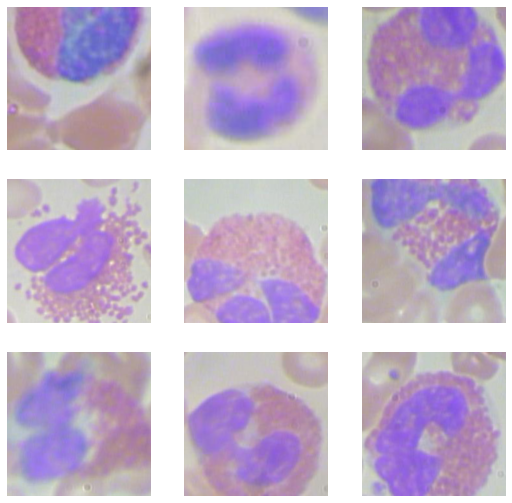

In [17]:
tst_files = get_image_files('/content/BCCD_cropped_wbc_classified_test_set')
tst_dl = learn.dls.test_dl(tst_files)
tst_dl.show_batch(max_n=9)

In [21]:
preds, _, decoded = learn.get_preds(dl=tst_dl, with_decoded=True)